# some research:

- can use the jax odeint(rungekatta) instead of chebyshev-gauss quadrature for better differentiability
- can use tinygp for kernels?
- let's try 3 things here. GP, EIV GP, and EIV IGP


In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
from jax import random
import jax
from numpyro.infer import MCMC, NUTS, Predictive
from scipy.spatial.distance import cdist
import time
import seaborn as sns
from tinygp import kernels, GaussianProcess

jax.config.update("jax_enable_x64", True)

print(numpyro.__version__)

0.16.1


In [2]:
df = pd.read_csv("./NYC.csv")
df

,Age,RSL,AgeError,RSLError,Type
0,1857.5000,-0.382722,1.25000,0.020224,TG
1,1865.0000,-0.390889,2.50000,0.019072,TG
2,1875.0000,-0.375111,2.50000,0.038143,TG
3,1895.0000,-0.303651,2.50000,0.019982,TG
4,1905.0000,-0.290822,2.50000,0.029349,TG
...,...,...,...,...,...
86,676.1125,-1.635141,47.94375,0.091382,Core
87,652.0000,-1.662090,48.00000,0.095789,Core
88,629.5000,-1.709393,47.75000,0.119915,Core
89,603.0000,-1.718310,45.50000,0.084227,Core


In [3]:
def standardize_with_uncertainties(x: pd.Series, x_error: pd.Series):
    """Standardize both values and their uncertainties"""
    x_std = x.std()
    x_mean = x.mean()

    # For the main values: (x - mean) / std
    x_standardized = ((x - x_mean) / x_std).to_numpy()

    # For uncertainties: only divide by std (don't subtract mean)
    x_error_standardized = (x_error / x_std).to_numpy()

    return x_standardized, x_error_standardized


x, x_err = standardize_with_uncertainties(df["Age"] / 1000, df["AgeError"] / 1000)
y, y_err = standardize_with_uncertainties(df["RSL"], df["RSLError"])


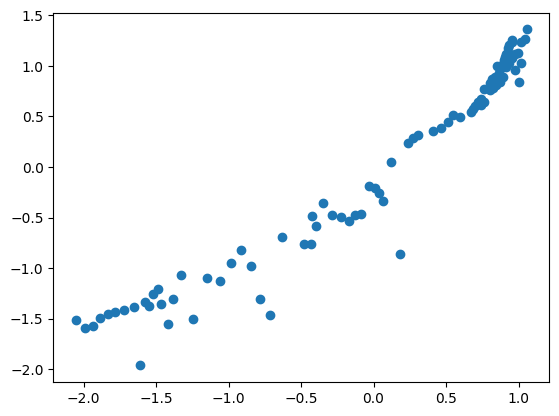

In [4]:
plt.scatter(x, y)

## GP


(100, 100)


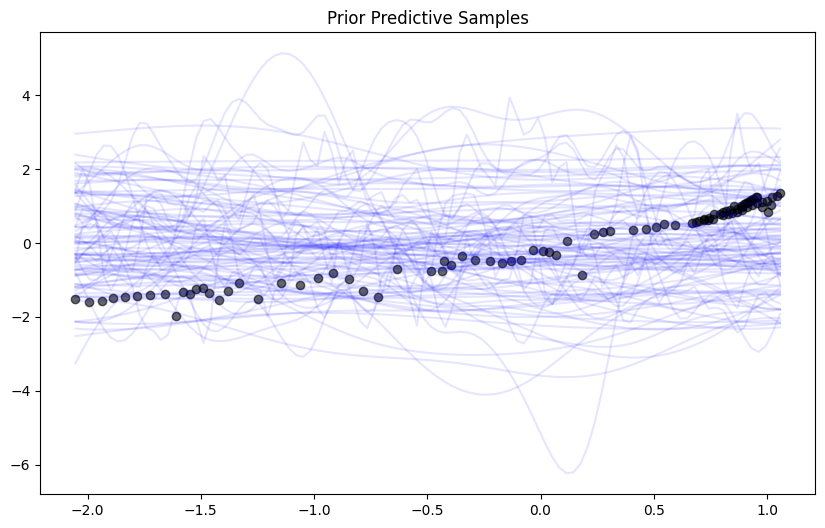

In [9]:
true_t = np.linspace(x.min(), x.max(), 100)


def model(x, y, y_err):
    mean = numpyro.sample("mean", dist.Normal(0.0, 1))
    jitter = numpyro.sample("jitter", dist.HalfNormal(1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))
    tau = numpyro.sample("tau", dist.HalfNormal(1))
    # distance = numpyro.sample("dist", dist.HalfNormal(0.2))
    kernel = sigma**2 * kernels.ExpSquared(tau)

    gp = GaussianProcess(kernel, x, mean=mean)
    # numpyro.sample("gp", gp.numpyro_dist(), obs=y)
    numpyro.sample("gp", gp.numpyro_dist())
    # Always compute predictions first
    # pred_gp = GaussianProcess(kernel, true_t, mean=mean)
    # numpyro.deterministic("pred", pred_gp.numpyro_dist())
    # if y is not None:
    #     numpyro.deterministic("pred", gp.condition(y, true_t).gp.loc)


# Sample from prior predictive
prior = Predictive(model, num_samples=100)
prior_samples = prior(random.PRNGKey(1), x=true_t, y=None, y_err=y_err)
prior_pred = prior_samples["gp"]
print(prior_pred.shape)

# Plot prior predictive samples
plt.figure(figsize=(10, 6))
for i in range(100):
    plt.plot(true_t, prior_pred[i], color="blue", alpha=0.1)
plt.scatter(x, y, alpha=0.6, color="black")
plt.title("Prior Predictive Samples")
plt.show()


In [ ]:
mcmc = MCMC(NUTS(model), num_warmup=100, num_samples=200)
mcmc.run(random.PRNGKey(0), x=x, y=y, y_err=y_err)
mcmc.print_summary()

In [ ]:
posterior = mcmc.get_samples()
pred = posterior["pred"].block_until_ready()
plt.scatter(x, y, alpha=0.6)
hpdi = numpyro.diagnostics.hpdi(pred, prob=0.9, axis=0)
plt.fill_between(true_t, hpdi[0], hpdi[1], alpha=0.2, color="black")

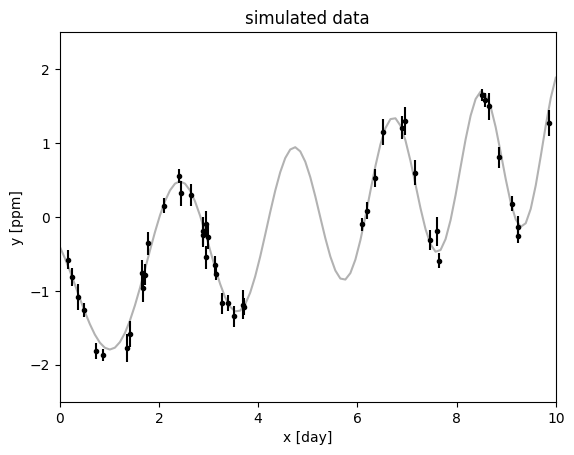

In [12]:
import numpy as np
import matplotlib.pyplot as plt

random = np.random.default_rng(42)

t = np.sort(
    np.append(
        random.uniform(0, 3.8, 28),
        random.uniform(5.5, 10, 18),
    )
)
yerr = random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * random.normal(size=len(t))
)

true_t = np.linspace(0, 10, 100)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")
plt.show()

prior_sigma = 5.0


def numpyro_model(t, yerr, y=None):
    mean = numpyro.sample("mean", dist.Normal(0.0, prior_sigma))
    jitter = numpyro.sample("jitter", dist.HalfNormal(prior_sigma))

    sigma1 = numpyro.sample("sigma1", dist.HalfNormal(prior_sigma))
    rho1 = numpyro.sample("rho1", dist.HalfNormal(prior_sigma))
    tau = numpyro.sample("tau", dist.HalfNormal(prior_sigma))
    kernel1 = sigma1**2 * kernels.ExpSquared(tau) * kernels.Cosine(rho1)

    sigma2 = numpyro.sample("sigma2", dist.HalfNormal(prior_sigma))
    rho2 = numpyro.sample("rho2", dist.HalfNormal(prior_sigma))
    kernel2 = sigma2**2 * kernels.Matern32(rho2)

    kernel = kernel1 + kernel2
    # we can specify mean function here
    gp = GaussianProcess(kernel, t, diag=yerr**2 + jitter, mean=mean)
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, true_t).gp.loc)


nuts_kernel = NUTS(numpyro_model, dense_mass=True, target_accept_prob=0.9)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=1,
    # progress_bar=False,
)
rng_key = jax.random.PRNGKey(34923)

In [13]:
mcmc.run(rng_key, t, yerr, y=y)
samples = mcmc.get_samples()
pred = samples["pred"].block_until_ready()

sample: 100%|██████████| 2000/2000 [00:06<00:00, 313.14it/s, 15 steps of size 1.76e-01. acc. prob=0.98]


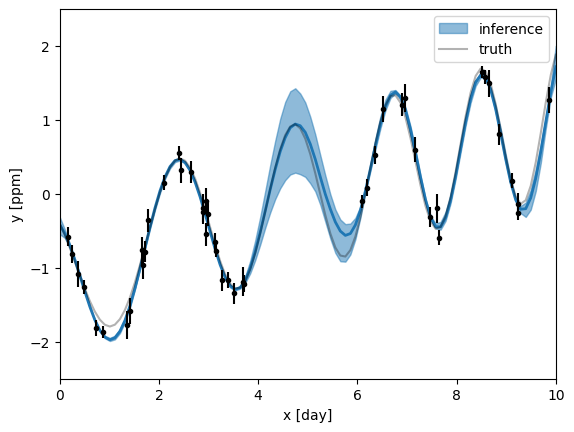

In [14]:
q = np.percentile(pred, [5, 50, 95], axis=0)
plt.fill_between(true_t, q[0], q[2], color="C0", alpha=0.5, label="inference")
plt.plot(true_t, q[1], color="C0", lw=2)
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
plt.legend()

In [51]:
x, x_err = standardize_with_uncertainties(df["Age"] / 1000, df["AgeError"] / 1000)
y, y_err = standardize_with_uncertainties(df["RSL"], df["RSLError"])
test_x = np.linspace(x.min(), x.max(), 100)


def gp_model(x, y, y_err, test_x):
    # jitter = numpyro.sample(
    #     "jitter", dist.HalfNormal(1)
    # )  # similar to microscale variance mentioned in paper
    scale = numpyro.sample("sigma", dist.HalfNormal(1))
    kernel = kernels.ExpSquared(scale)
    gp = GaussianProcess(kernel, x, diag=y_err**2)
    # gp = GaussianProcess(kernel, x, diag=1e-1)
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        conditioned_gp = gp.condition(y, test_x).gp
        numpyro.deterministic("pred", conditioned_gp.loc)
        numpyro.deterministic("sd", jnp.sqrt(conditioned_gp.variance))


mcmc = MCMC(
    NUTS(gp_model, dense_mass=True, target_accept_prob=0.9),
    num_warmup=1000,
    num_samples=1000,
)
mcmc.run(jax.random.PRNGKey(0), x=x, y=y, y_err=y_err, test_x=test_x)
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:02<00:00, 756.63it/s, 1 steps of size 5.36e-01. acc. prob=0.97] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      0.59      0.08      0.60      0.46      0.74    334.74      1.00

Number of divergences: 0


In [52]:
samples = mcmc.get_samples()
# predictive = Predictive(gp_model, samples)
# posterior_predictive = predictive(
#     jax.random.PRNGKey(0), x=x, y=y, y_err=y_err, test_x=test_x
# )
pred = samples["pred"]
# sd = posterior_predictive["sd"]
pred.shape

(1000, 100)

Text(0, 0.5, 'Standardized RSL')

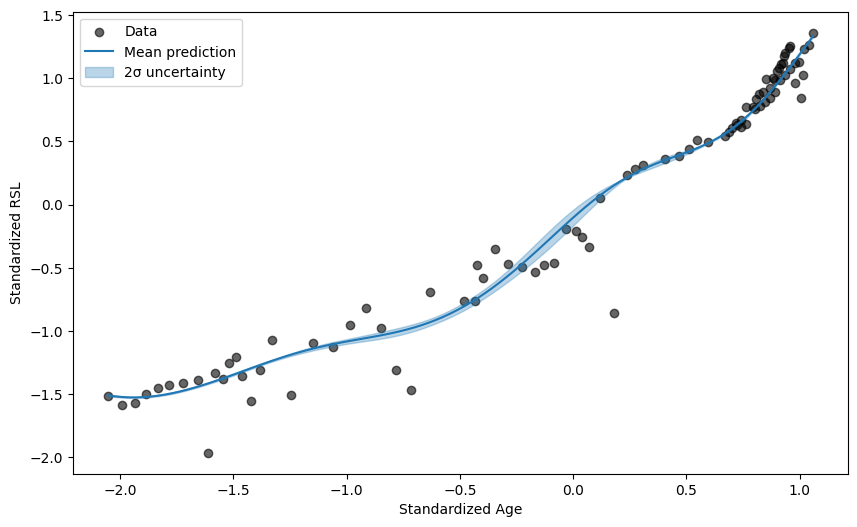

In [53]:
pred_mean = np.mean(pred, axis=0)
# total_sd = np.sqrt(np.mean(sd**2, axis=0))  # combining GP uncertainty
total_sd = np.std(pred, axis=0)  # emprical sd

# Plot mean and uncertainty bands
plt.figure(figsize=(10, 6))

# Plot data points
plt.scatter(x, y, color="black", alpha=0.6, label="Data")

# Plot mean prediction
plt.plot(test_x, pred_mean, "C0", label="Mean prediction")

# Plot ±2 standard deviation bands (95% confidence interval)
plt.fill_between(
    test_x,
    pred_mean - 2 * total_sd,
    pred_mean + 2 * total_sd,
    color="C0",
    alpha=0.3,
    label="2σ uncertainty",
)

plt.legend()
plt.xlabel("Standardized Age")
plt.ylabel("Standardized RSL")

In [60]:
import tinygp


class PoweredExponential(tinygp.kernels.Kernel):
    p: jax.Array  # length scale parameter
    kappa: jax.Array  # power parameter (between 0 and 2)

    def evaluate(self, X1, X2):
        # D = jnp.sqrt((X1 - X2) ** 2)
        D = jnp.abs((X1 - X2))
        return self.p ** (D**self.kappa)


In [61]:
def eiv_gp_model(x, y, x_err, y_err, test_x):
    jitter = numpyro.sample(
        "jitter", dist.HalfNormal(1)
    )  # similar to microscale variance mentioned in paper
    # scale = numpyro.sample("sigma", dist.HalfNormal(1))
    p = numpyro.sample("p", dist.Uniform(0, 1))
    # kernel = kernels.ExpSquared(scale)
    kernel = PoweredExponential(p=p, kappa=1.99)

    chi = numpyro.sample(
        "chi", dist.Normal(jnp.mean(x), jnp.std(x)), sample_shape=(len(x),)
    )

    gp = GaussianProcess(kernel, chi, diag=y_err**2 + jitter)

    numpyro.sample("gp", gp.numpyro_dist(), obs=y)
    numpyro.sample("x_obs", dist.Normal(chi, x_err), obs=x)

    if y is not None:
        conditioned_gp = gp.condition(y, test_x).gp
        numpyro.deterministic("pred", conditioned_gp.loc)


mcmc = MCMC(
    NUTS(eiv_gp_model, dense_mass=True, target_accept_prob=0.9),
    num_warmup=1000,
    num_samples=1000,
)
mcmc.run(jax.random.PRNGKey(0), x=x, y=y, x_err=x_err, y_err=y_err, test_x=test_x)
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:33<00:00, 59.11it/s, 15 steps of size 2.93e-01. acc. prob=0.92] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    chi[0]      0.72      0.00      0.72      0.72      0.73   1239.58      1.00
    chi[1]      0.74      0.01      0.74      0.73      0.75   2138.03      1.00
    chi[2]      0.76      0.01      0.76      0.75      0.77   1998.77      1.00
    chi[3]      0.80      0.01      0.80      0.79      0.81   2476.05      1.00
    chi[4]      0.82      0.01      0.82      0.82      0.83   2533.34      1.00
    chi[5]      0.85      0.01      0.85      0.84      0.85   1953.84      1.00
    chi[6]      0.87      0.01      0.87      0.86      0.88   2149.04      1.00
    chi[7]      0.89      0.01      0.89      0.88      0.90   2310.99      1.00
    chi[8]      0.91      0.01      0.91      0.90      0.92   1765.24      1.00
    chi[9]      0.93      0.01      0.93      0.92      0.94   2326.95      1.00
   chi[10]      0.95      0.01      0.96      0.95      0.96   1679.25      1.00
   chi[11]      0.98      0

Text(0, 0.5, 'Standardized RSL')

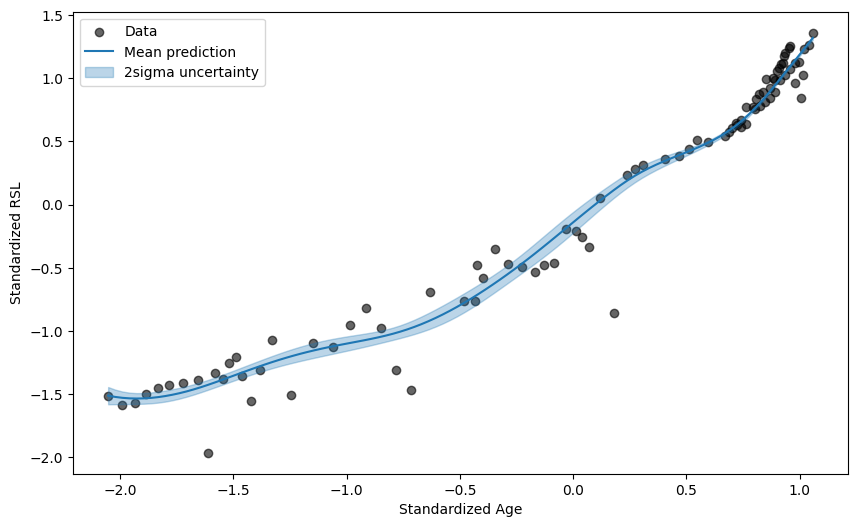

In [62]:
samples = mcmc.get_samples()
pred = samples["pred"]
pred_mean = np.mean(pred, axis=0)
total_sd = np.std(pred, axis=0)  # emprical sd

plt.figure(figsize=(10, 6))
plt.scatter(x, y, color="black", alpha=0.6, label="Data")
plt.plot(test_x, pred_mean, "C0", label="Mean prediction")
plt.fill_between(
    test_x,
    pred_mean - 2 * total_sd,
    pred_mean + 2 * total_sd,
    color="C0",
    alpha=0.3,
    label="2sigma uncertainty",
)

plt.legend()
plt.xlabel("Standardized Age")
plt.ylabel("Standardized RSL")

In [63]:
from jax.experimental.ode import odeint

integral_bounds = ((x - x_err).min(), (x + x_err).max())
integral_bounds

(-2.1419102308347413, 1.0603656373130124)

In [ ]:
def eiv_igp_model(x, y, x_err, y_err, test_x):
    jitter = numpyro.sample(
        "jitter", dist.HalfNormal(1)
    )  # similar to microscale variance mentioned in paper
    scale = numpyro.sample("sigma", dist.HalfNormal(1))
    kernel = kernels.ExpSquared(scale)

    chi = numpyro.sample(
        "chi", dist.Normal(jnp.mean(x), jnp.std(x)), sample_shape=(len(x),)
    )

    gp = GaussianProcess(kernel, chi, diag=y_err**2 + jitter)

    numpyro.sample("x_obs", dist.Normal(chi, x_err), obs=x)
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        conditioned_gp = gp.condition(y, test_x).gp
        numpyro.deterministic("pred", conditioned_gp.loc)


mcmc = MCMC(
    NUTS(eiv_igp_model, dense_mass=True, target_accept_prob=0.9),
    num_warmup=1000,
    num_samples=1000,
)
mcmc.run(jax.random.PRNGKey(0), x=x, y=y, x_err=x_err, y_err=y_err, test_x=test_x)
mcmc.print_summary()

In [66]:
from diffrax import diffeqsolve, ODETerm, Dopri5
import jax.numpy as jnp


def f(t, y, args):
    return -y


term = ODETerm(f)
solver = Dopri5()
y0 = jnp.array([2.0, 3.0])
solution = diffeqsolve(term, solver, t0=0, t1=1, dt0=0.1, y0=y0)
solution

Solution(
  t0=f64[],
  t1=f64[],
  ts=f64[1],
  ys=f64[1,2],
  interpolation=None,
  stats={
    'max_steps':
    4096,
    'num_accepted_steps':
    weak_i64[],
    'num_rejected_steps':
    weak_i64[],
    'num_steps':
    weak_i64[]
  },
  result=EnumerationItem(
    _value=i32[],
    _enumeration=<class 'diffrax._solution.RESULTS'>
  ),
  solver_state=None,
  controller_state=None,
  made_jump=None,
  event_mask=None
)